In [382]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

In [383]:
df_ratio_cpu = pd.read_csv('NAB/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv')

In [384]:
print(df_ratio_cpu.head())
print(df_ratio_cpu.tail())

             timestamp  value
0  2014-02-14 14:30:00  0.132
1  2014-02-14 14:35:00  0.134
2  2014-02-14 14:40:00  0.134
3  2014-02-14 14:45:00  0.134
4  2014-02-14 14:50:00  0.134
                timestamp  value
4027  2014-02-28 14:05:00  0.132
4028  2014-02-28 14:10:00  0.134
4029  2014-02-28 14:15:00  0.134
4030  2014-02-28 14:20:00  0.134
4031  2014-02-28 14:25:00  0.134


In [385]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

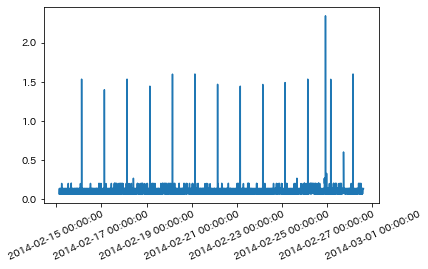

In [386]:
plot_dates_values(df_ratio_cpu[152:])

In [387]:
index_devide =  df_ratio_cpu[df_ratio_cpu["timestamp"]=="2014-02-26 00:00:00"].index[0]

In [388]:
df_small_noise = df_ratio_cpu[:index_devide]
df_daily_jumpsup = df_ratio_cpu[index_devide:]

In [389]:
print(df_small_noise.head())
print(df_small_noise.tail())


             timestamp  value
0  2014-02-14 14:30:00  0.132
1  2014-02-14 14:35:00  0.134
2  2014-02-14 14:40:00  0.134
3  2014-02-14 14:45:00  0.134
4  2014-02-14 14:50:00  0.134
                timestamp  value
3277  2014-02-25 23:35:00  0.134
3278  2014-02-25 23:40:00  0.066
3279  2014-02-25 23:45:00  0.134
3280  2014-02-25 23:50:00  0.134
3281  2014-02-25 23:55:00  0.202


In [390]:
print(df_daily_jumpsup.head())
print(df_daily_jumpsup.tail())

                timestamp  value
3282  2014-02-26 00:00:00  0.066
3283  2014-02-26 00:05:00  0.200
3284  2014-02-26 00:10:00  0.134
3285  2014-02-26 00:15:00  0.066
3286  2014-02-26 00:20:00  0.132
                timestamp  value
4027  2014-02-28 14:05:00  0.132
4028  2014-02-28 14:10:00  0.134
4029  2014-02-28 14:15:00  0.134
4030  2014-02-28 14:20:00  0.134
4031  2014-02-28 14:25:00  0.134


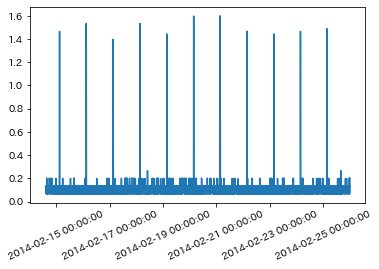

In [391]:
plot_dates_values(df_small_noise)

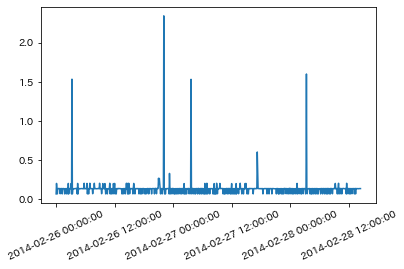

(750, 2)


In [449]:
plot_dates_values(df_daily_jumpsup)
print(df_daily_jumpsup.shape)

In [393]:
def get_value_from_df(df):
    return df.value.to_list()

def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std


training_value = get_value_from_df(df_small_noise)

training_value, training_mean, training_std = normalize(training_value)
len(training_value)

3282

In [576]:
TIME_STEPS = 100#12#288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
        
    return np.expand_dims(output, axis=2)

x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (3182, 100, 1)


In [577]:
ks = 7
strides = 2

model = keras.Sequential()
model.add(layers.Input(shape=(x_train.shape[1], x_train.shape[2])))

model.add(layers.Conv1D(filters=64, kernel_size=8, padding="same", strides=strides, activation="relu"))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv1D(filters=128, kernel_size=ks, padding="same", strides=strides, activation="relu"))
model.add(layers.Conv1DTranspose(filters=16, kernel_size=6, padding="same", strides=strides, activation="relu"))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv1DTranspose(filters=256, kernel_size=4, padding="same", strides=strides, activation="relu"))

model.add(layers.Conv1DTranspose(filters=1, kernel_size=ks, padding="same"))

#model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
model.compile(optimizer=keras.optimizers.Adam(amsgrad=True), loss="mse")
model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 50, 64)            576       
_________________________________________________________________
dropout_114 (Dropout)        (None, 50, 64)            0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 25, 128)           57472     
_________________________________________________________________
conv1d_transpose_171 (Conv1D (None, 50, 16)            12304     
_________________________________________________________________
dropout_115 (Dropout)        (None, 50, 16)            0         
_________________________________________________________________
conv1d_transpose_172 (Conv1D (None, 100, 256)          16640     
_________________________________________________________________
conv1d_transpose_173 (Conv1D (None, 100, 1)          

In [578]:
history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=4,
    validation_split=0.1,
    #shuffle=False,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")]
)

Epoch 1/100
716/716 [==============================] - 6s 9ms/step - loss: 0.0925 - val_loss: 0.0205
Epoch 2/100
716/716 [==============================] - 5s 8ms/step - loss: 0.0270 - val_loss: 0.0088
Epoch 3/100
716/716 [==============================] - 6s 8ms/step - loss: 0.0191 - val_loss: 0.0139
Epoch 4/100
716/716 [==============================] - 6s 8ms/step - loss: 0.0144 - val_loss: 0.0196
Epoch 5/100
716/716 [==============================] - 6s 8ms/step - loss: 0.0122 - val_loss: 0.0162
Epoch 6/100
716/716 [==============================] - 5s 8ms/step - loss: 0.0117 - val_loss: 0.0067
Epoch 7/100
716/716 [==============================] - 6s 8ms/step - loss: 0.0125 - val_loss: 0.0085
Epoch 8/100
716/716 [==============================] - 6s 8ms/step - loss: 0.0093 - val_loss: 0.0060
Epoch 9/100
716/716 [==============================] - 6s 8ms/step - loss: 0.0078 - val_loss: 0.0152
Epoch 10/100
716/716 [==============================] - 6s 8ms/step - loss: 0.0071 - val_lo

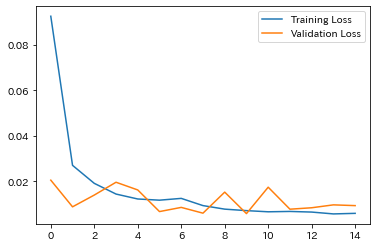

In [586]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

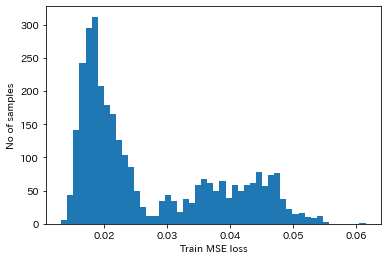

Reconstruction error threshold:  0.06145418567725045


In [587]:
x_train_pred = model.predict(x_train)
#train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
train_mse_loss = np.mean(np.sqrt((x_train_pred - x_train)**2), axis=1)

#plt.hist(train_mae_loss, bins=50)
#plt.xlabel("Train MAE loss")
plt.hist(train_mse_loss, bins=50)
plt.xlabel("Train MSE loss")
plt.ylabel("No of samples")
plt.show()

threshold = np.max(train_mse_loss)
print("Reconstruction error threshold: ", threshold)

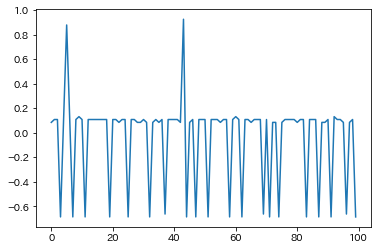

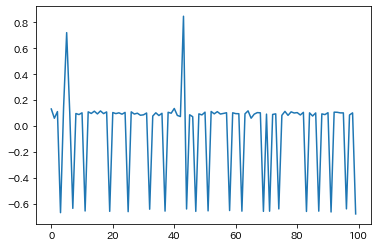

In [588]:
plt.plot(x_train[264])
plt.show()
plt.plot(x_train_pred[264])
plt.show()

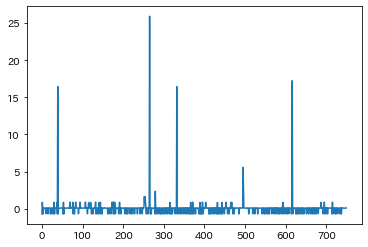

Test input shape:  (650, 100, 1)


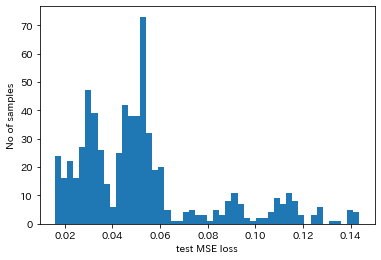

Number of anomaly samples:  127
Indices of anomary samples;  (array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 267, 306, 310, 315, 326, 327, 331], dtype=int64),)


In [589]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

test_value = get_value_from_df(df_daily_jumpsup)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value)
plt.show()


x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

x_test_pred = model.predict(x_test)
#test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
#test_mae_loss = test_mae_loss.reshape((-1))

test_mse_loss = np.mean(np.sqrt((x_test_pred - x_test)**2), axis=1)
test_mse_loss = test_mse_loss.reshape((-1))

#plt.hist(test_mae_loss, bins=50)
#plt.xlabel("test MAE loss")
#plt.ylabel("No of samples")
plt.hist(test_mse_loss, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()


anomalies = (test_mse_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomary samples; ", np.where(anomalies))

In [590]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

In [591]:
anomalous_data_indices

[265, 266]

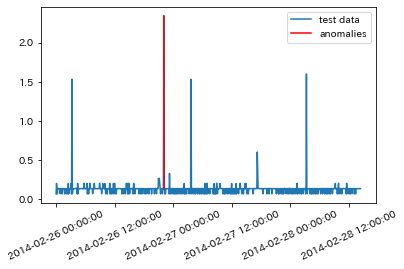

In [592]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = df_daily_jumpsup["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_daily_jumpsup["value"].to_list()
plt.plot(dates, values, label="test data")


dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()

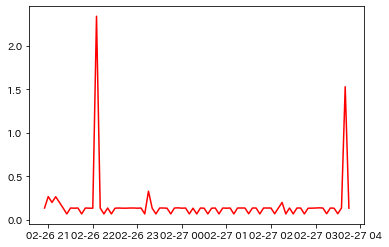

In [575]:
dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

In [216]:
dates

[]